In [71]:
%pip install pingouin diptest


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: /home/nwelch/projects/nlp-alignment/.venv/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [34]:
import pandas as pd
import numpy as np

In [2]:
llm_ajt = pd.read_csv("../results.csv")
human_ajt = pd.read_csv("../human-results.csv")

We'll start by taking the median Likert score from LLM AJT responses.

In [3]:
llm_medians = llm_ajt.groupby(["model", "stimulus_number"])["acceptability_rating"].median().reset_index()
llm_medians

,model,stimulus_number,acceptability_rating
0,anthropic/claude-3-7-sonnet-20250219:thinking,79,5.0
1,anthropic/claude-3-7-sonnet-20250219:thinking,80,5.0
2,anthropic/claude-3-7-sonnet-20250219:thinking,81,5.0
3,anthropic/claude-3-7-sonnet-20250219:thinking,82,5.0
4,anthropic/claude-3-7-sonnet-20250219:thinking,83,5.0
...,...,...,...
1525,qwen/qwen-2.5-72b-instruct,176,5.0
1526,qwen/qwen-2.5-72b-instruct,177,5.0
1527,qwen/qwen-2.5-72b-instruct,178,5.0
1528,qwen/qwen-2.5-72b-instruct,179,5.0


Now we will isolate columns of interest from the human response data. Specifically, we look at those that encode demographic information.

There is some irregularity in these columns, so we will do our best to normalize before proceeding with our analysis.

In [4]:
# Normalize gender
human_ajt["gender_normed"] = human_ajt["gender"].str.lower().str.strip().map({
    "female": "GENDER_F",
    "woman": "GENDER_F",
    "male": "GENDER_M",
    "cis male": "GENDER_M",
    "hispanic": np.nan
})
human_ajt["gender_normed"].unique()

array(['GENDER_F', 'GENDER_M', nan], dtype=object)

In [5]:
# Normalize education
human_ajt["education_normed"] = human_ajt["education"].str.lower().str.strip().map({
    "some college": "ED_COLLEGE",
    "college": "ED_COLLEGE",
    "phd/md/jd": "ED_GRADUATE",
    "masters": "ED_GRADUATE",
    "some graduate school": "ED_GRADUATE",
    "high school": "ED_HIGHSCHOOL"
})
human_ajt["education_normed"].unique()

array(['ED_COLLEGE', 'ED_GRADUATE', 'ED_HIGHSCHOOL'], dtype=object)

In [6]:
# Normalize cultural identity
human_ajt["culture_normed"] = human_ajt["cultural_id"].str.lower().str.strip().map({
    'hispanic': 'CULTURE_LATINO',
    'mexican, latinx': 'CULTURE_MEXICAN',
    'mexican puerto rican': 'CULTURE_MEXICAN_PUERTO_RICAN', 
    'mexican-american': 'CULTURE_MEXICAN',
    'latino/mexicano': 'CULTURE_MEXICAN',
    'mexican american': 'CULTURE_MEXICAN',
    'mexican/american': 'CULTURE_MEXICAN',
    'mexican/indian': 'CULTURE_MEXICAN_INDIGENOUS',
    'mexican': 'CULTURE_MEXICAN',
    'latino': 'CULTURE_LATINO',
    'hispanic/mexican': 'CULTURE_MEXICAN',
    'hispanic- venezuelan': 'CULTURE_VENEZUELAN',
    'latino/hispanic': 'CULTURE_LATINO',
    'chicano': 'CULTURE_MEXICAN'
})
human_ajt["culture_normed"].unique()

array(['CULTURE_LATINO', 'CULTURE_MEXICAN',
       'CULTURE_MEXICAN_PUERTO_RICAN', 'CULTURE_MEXICAN_INDIGENOUS', nan,
       'CULTURE_VENEZUELAN'], dtype=object)

Now, how many human and LLM raters do we have?

In [44]:
print(f"Human raters: {human_ajt["participant"].nunique()}")
print(f"LLM raters: {llm_medians["model"].nunique()}")

Human raters: 21
LLM raters: 15


And how many unique utterances?

In [25]:
print(f"Utterances: {human_ajt["stimulus_number"].nunique()}")

Utterances: 48


Just to be sure, let's check if all raters have rated all stimuli:

In [32]:
n_missing = 0
for utterance_id in human_ajt["stimulus_number"].unique():
    for participant in human_ajt["participant"].unique():
        if human_ajt[(human_ajt["stimulus_number"] == utterance_id) & (human_ajt["participant"] == participant)].empty:
            n_missing += 1

assert n_missing == 0

Let's calculate some inter-rater agreement (IRA) stats on Likert-scale rating of utterance acceptability by humans and LLMs. Our two key questions are: how much do acceptability judgment ratings tend to vary between annotators, and can we justify rating aggregation? This will be useful later.

We'll use $\text{ICC}(3, k)$ as our measure of group-wide rating consistency. We will also calculate $\text{ICC}(3, 1)$ to quantify single-rater consistency.

In [45]:
import pingouin as pg

# Reshape our data so that each column is a rater and each row is an utterance
human_ratings = human_ajt.pivot(
    index="stimulus_number",
    columns="participant",
    values="rating",
)

human_ratings_long = human_ratings.reset_index().melt(
    id_vars="stimulus_number",  # target
    var_name="participant",  # rater
    value_name="rating",  # Likert score
)
human_ratings_long.columns = ["target", "rater", "rating"]

human_icc = pg.intraclass_corr(
    data=human_ratings_long,
    targets="target",
    raters="rater",
    ratings="rating"
)
print("Human ICC results:")
print(human_icc[human_icc["Type"].isin(["ICC3", "ICC3k"])])

Human ICC results:
    Type           Description       ICC         F  df1  df2          pval  \
2   ICC3   Single fixed raters  0.079898  2.823559   47  940  2.697919e-09   
5  ICC3k  Average fixed raters  0.645837  2.823559   47  940  2.697919e-09   

          CI95%  
2  [0.04, 0.14]  
5  [0.48, 0.78]  


In [46]:
import pingouin as pg

# Do the same for LLM data 

# Reshape our data so that each column is a rater and each row is an utterance
llm_ratings = llm_medians.pivot(
    index="stimulus_number",
    columns="model",
    values="acceptability_rating",
)

llm_ratings_long = llm_ratings.reset_index().melt(
    id_vars="stimulus_number",  # target
    var_name="model",  # rater
    value_name="acceptability_rating",  # Likert score
)
llm_ratings_long.columns = ["target", "rater", "rating"]

llm_icc = pg.intraclass_corr(
    data=llm_ratings_long,
    targets="target",
    raters="rater",
    ratings="rating"
)
print("LLM ICC results:")
print(llm_icc[llm_icc["Type"].isin(["ICC3", "ICC3k"])])

LLM ICC results:
    Type           Description       ICC          F  df1   df2           pval  \
2   ICC3   Single fixed raters  0.540449  18.640546  101  1414  1.698941e-194   
5  ICC3k  Average fixed raters  0.946354  18.640546  101  1414  1.698941e-194   

          CI95%  
2  [0.47, 0.62]  
5  [0.93, 0.96]  


Let's take a look at what median agreement looks like for LLM- vs human-generated acceptability judgments.

Pearson r = 0.66, p = 3.757e-07


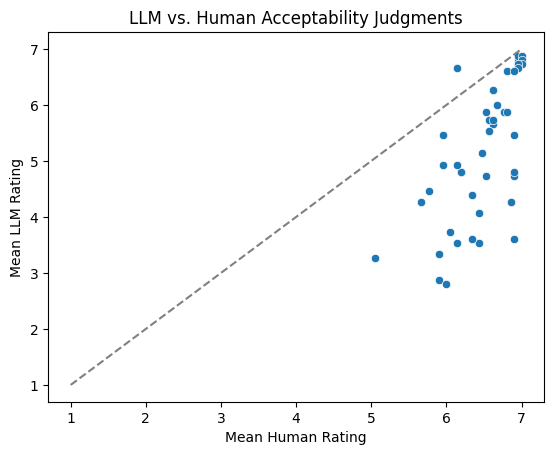

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

stims = human_ajt

mean_human = human_ajt.sort_values(by="stimulus_number").groupby("stimulus_number")["rating"].mean()
mean_llm = llm_medians[llm_medians["stimulus_number"].isin(human_ajt["stimulus_number"].unique())].sort_values(by="stimulus_number").groupby("stimulus_number")["acceptability_rating"].mean()

sns.scatterplot(x=mean_human, y=mean_llm)
plt.plot([1, 7], [1, 7], linestyle='--', color='gray')
plt.xlabel("Mean Human Rating")
plt.ylabel("Mean LLM Rating")
plt.title("LLM vs. Human Acceptability Judgments")

r, p = pearsonr(mean_human, mean_llm)
print(f"Pearson r = {r:.2f}, p = {p:.3e}")

Text(0, 0.5, 'Z-scored LLM Mean Ratings')

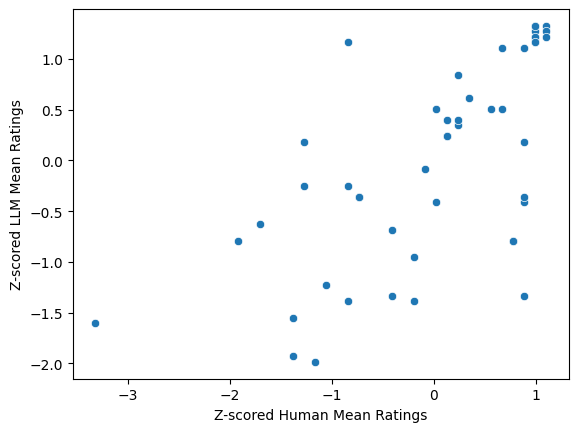

In [57]:
from scipy.stats import zscore

z_human = zscore(mean_human)
z_llm = zscore(mean_llm)

sns.scatterplot(x=z_human, y=z_llm)
plt.xlabel("Z-scored Human Mean Ratings")
plt.ylabel("Z-scored LLM Mean Ratings")

Text(0.5, 0, 'LLM - Human Rating Difference')

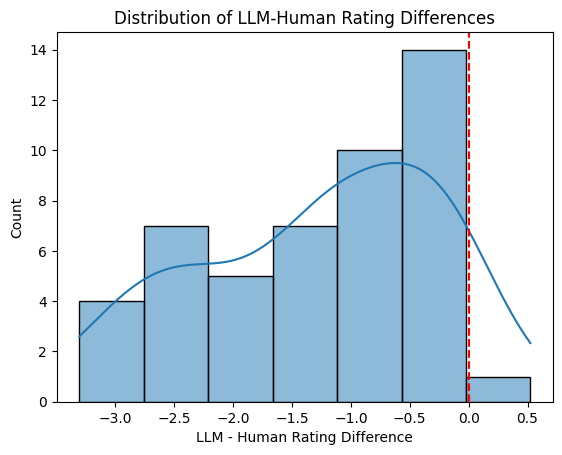

In [52]:
diffs = mean_llm - mean_human
sns.histplot(diffs, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution of LLM-Human Rating Differences")
plt.xlabel("LLM - Human Rating Difference")

Text(0, 0.5, 'LLM - Human Rating')

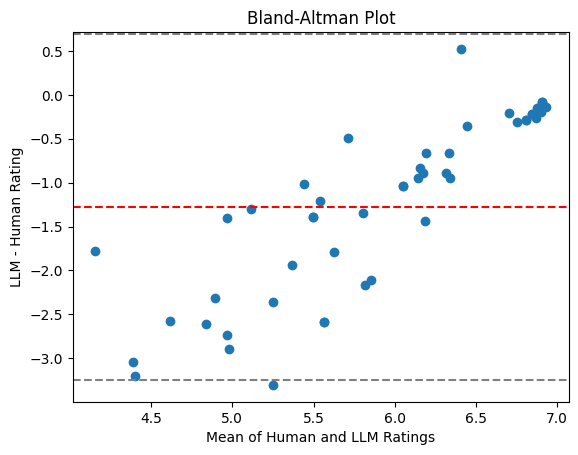

In [54]:
import matplotlib.pyplot as plt
means = (mean_llm + mean_human) / 2
diffs = mean_llm - mean_human
plt.scatter(means, diffs)
plt.axhline(diffs.mean(), color='red', linestyle='--')
plt.axhline(diffs.mean() + 1.96*diffs.std(), color='gray', linestyle='--')
plt.axhline(diffs.mean() - 1.96*diffs.std(), color='gray', linestyle='--')
plt.title("Bland-Altman Plot")
plt.xlabel("Mean of Human and LLM Ratings")
plt.ylabel("LLM - Human Rating")

Let's try to find utterances with relatively high standard deviation across human-generated ratings, but low standard deviation across LLM-generated ratings.

{79: (np.float64(1.3627702877384935), np.float64(1.3688452701957858)),
 80: (np.float64(2.0953463175513947), np.float64(1.3588468075778988)),
 81: (np.float64(2.243509156061845), np.float64(1.1560119533826785)),
 82: (np.float64(2.6735031415016235), np.float64(1.1797962501716948)),
 83: (np.float64(1.3645163106041502), np.float64(1.0357254813546264)),
 84: (np.float64(1.4259499757471625), np.float64(1.3915328369692312)),
 85: (np.float64(1.558387444947959), np.float64(1.1772249512555304)),
 86: (np.float64(2.0953463175513947), np.float64(1.1642832797715323)),
 87: (np.float64(0.7003400534570262), np.float64(0.8480518375617843)),
 88: (np.float64(0.30079260375911915), np.float64(1.254486896598515)),
 89: (np.float64(0.35856858280031817), np.float64(1.133957047625079)),
 90: (np.float64(1.6604646509766043), np.float64(1.1000459127241053)),
 91: (np.float64(1.164964745021435), np.float64(1.178511301977579)),
 92: (np.float64(1.8060744065250363), np.float64(1.2949006435891817)),
 93: (np.f

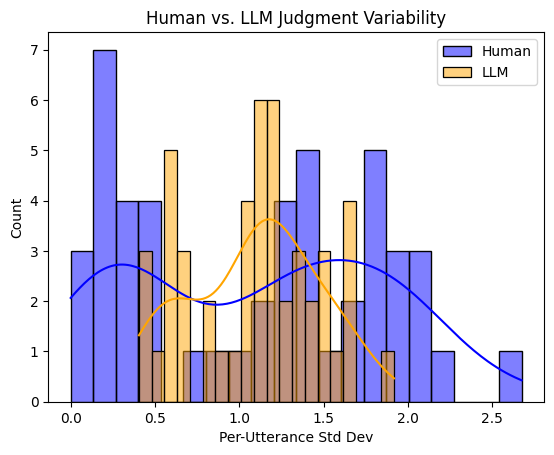

In [77]:
import matplotlib.pyplot as plt

utterance_std = {}
human_stds = {}
llm_stds = {}

for utterance_id in human_ajt["stimulus_number"].unique():
    human_std = human_ajt[human_ajt["stimulus_number"] == utterance_id]["rating"].std()
    llm_std = llm_ajt[llm_ajt["stimulus_number"] == utterance_id]["acceptability_rating"].std()
    # Keep only examples with high human standard deviation and low LLM standard deviation (semi-arbitrary)
    # if human_std > 1.0 and llm_std < 0.3:
    human_stds[int(utterance_id)] = human_std
    llm_stds[int(utterance_id)] = llm_std
    utterance_std[int(utterance_id)] = (human_std, llm_std)
    
sns.histplot(list(human_stds.values()), label="Human", bins=20, color="blue", kde=True)
sns.histplot(list(llm_stds.values()), label="LLM", bins=20, color="orange", kde=True)
plt.xlabel("Per-Utterance Std Dev")
plt.title("Human vs. LLM Judgment Variability")
plt.legend()

utterance_std

The distribution of standard deviations of human-generated ratings appears to be roughly bimodal; let's perform some tests to see if that's the case.

In [79]:
from scipy.stats import kurtosis, skew
import numpy as np

def bimodality_coefficient(data):
    n = len(data)
    s = skew(data)
    k = kurtosis(data, fisher=False)
    bc = (s**2 + 1) / k
    return bc

bc_human = bimodality_coefficient(list(human_stds.values()))
bc_llm = bimodality_coefficient(list(llm_stds.values()))

bc_human, bc_llm

(np.float64(0.5856030576348179), np.float64(0.454566980601847))

Human rating standard deviations show a bimodality coefficient above 0.555. Let's perform Hartigan's dip test to investigate whether we have a bimodal distribution in a more rigorous manner.

In [80]:
from diptest import diptest

dip_h, pval_h = diptest(pd.Series(human_stds.values()))
dip_l, pval_l = diptest(pd.Series(llm_stds.values()))

print(f"Human SDs:\tdip = {dip_h:.4f}, p = {pval_h:.4g}")
print(f"LLM SDs:\tdip = {dip_l:.4f}, p = {pval_l:.4g}")

Human SDs:	dip = 0.0897, p = 0.00333
LLM SDs:	dip = 0.0485, p = 0.5462


The analysis thus far strongly supports the hypothesis that the variability of human-generated acceptablity ratings for utterances from the K&D study follows a bimodal distribution. Let's look at some examples from each of the two "peaks" in standard deviation.

In [85]:
high_human_std = [
    key for key, val in human_stds.items()
    if val > 1.75
]

low_human_std = [
    key for key, val in human_stds.items()
    if val < 0.5
]

print("High standard deviations:", llm_ajt[llm_ajt["stimulus_number"].isin(high_human_std)]["utterance"].unique())
print("Low standard deviations:", llm_ajt[llm_ajt["stimulus_number"].isin(low_human_std)]["utterance"].unique())

High standard deviations: ['He was called estúpido todo el tiempo.'
 'Le llamaba boneheaded all the time.' 'Le llamaba stupid all the time.'
 'Le llamaba native because he was from the US.'
 'I have been craving café desde la mañana.'
 'He tenido antojo de seltzer since this morning.'
 'He tenido antojo de coffee since this morning.'
 'Nos va a servir soup for dinner tomorrow.'
 'Le llamaba naco todo el tiempo.' 'Le llamaba estúpido todo el tiempo.'
 'Le llamaba chicano porque era mexicano.'
 'Le llamaba nativo porque era mexicano.'
 'He tenido antojo de champurrado desde la mañana.']
Low standard deviations: ['My mom bought fruta para la fiesta.'
 'Mi mamá compró crackers for the party.'
 'My grandma made me panqueques para el desayuno.'
 'Mi abuela me hizo biscuits for breakfast.'
 'Mi abuela me hizo pancakes for breakfast.'
 'Mi mamá compró nopales para la fiesta.'
 'Mi mamá compró fruta para la fiesta.'
 'Mi abuela me hizo atole para el desayuno.'
 'Mi abuela me hizo panqueques par